# 🧪 Domain Adaptation with Synthetic and Real Data (Brysthol vs Grenoble)


In [1]:
from utils import *
from sklearn.decomposition import PCA 

c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Data Generation & Preprocessing

We simulate source (Brysthol) and target (Grenoble) datasets using custom preprocessing functions. 
The data is then transformed into a common format for downstream VAE training.


In [2]:
# Generate synthetic Brysthol signals (source domain)
params_brysthol = {
    'size': 5500,
    'prop': 0.5,          # proportion of anomaly class
    'low': 30,            # min window start
    'high': 700,          # max window start
    'plot': True,
    'fail_id': 1,         # ID for anomaly class
    'window_size': 500,
    'dataset': 'source'
}

X_noise_brysthol, y_brysthol, sample_id_brysthol = preprocess_random_brysthol(
    list(range(75)), params_brysthol
)


In [3]:
# Generate Grenoble signals (target domain, unlabeled)
params_grenoble = {
    'size': 5500,
    'prop': 0,            # no labels in target domain
    'low': 30,
    'high': 700,
    'plot': True,
    'fail_id': -1,
    'window_size': 500,
    'dataset': 'target'
}

X_noise_grenoble, sample_id_grenoble, composition_grenoble = preprocess_random_grenoble(params_grenoble)


In [4]:
# Transform Brysthol & Grenoble into VAE-ready format
params_trans = {'im_size': 28}

X_noise_brysthol, X_noise_grenoble, X_vae_brysthol, X_vae_grenoble = process_combined_data(
    X_noise_brysthol,
    X_noise_grenoble,
    params_trans
)


In [5]:
# ✅ Sanity checks
assert X_noise_brysthol.shape[0] == X_vae_brysthol.shape[0]
assert X_noise_brysthol.shape[0] == y_brysthol.shape[0]
assert X_noise_brysthol.shape[0] == sample_id_brysthol.shape[0]
assert X_vae_brysthol.shape[1] == 3                         # RGB or multi-channel
assert np.sum(X_noise_brysthol < 0) == 0                    # Expect normalized data
assert np.sum(X_noise_brysthol > 1) == 0


In [6]:
assert X_noise_grenoble.shape[0]==X_vae_grenoble.shape[0]
assert X_noise_grenoble.shape[0]==sample_id_grenoble.shape[0]
assert X_vae_grenoble.shape[1]==3
assert np.sum(X_noise_grenoble<0)==0
assert np.sum(X_noise_grenoble>1)==0

## Visualizing Signal and Image Encodings (GADF, GASF, MTF)
Below we visualize the noise signal and its corresponding image transformations 
for a Brysthol (source) and a Grenoble (target) sample.


In [7]:
def visualize_sample(signal, image, sample_id, dataset_name):
    """
    Visualize a time-series signal alongside its GADF, GASF, and MTF image encodings.

    Args:
        signal (np.ndarray): 1D time-series signal
        image (np.ndarray): Image tensor of shape [3, H, W] with channels [GADF, GASF, MTF]
        sample_id (int): Index of the sample being visualized
        dataset_name (str): 'Brysthol' or 'Grenoble'
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(f"{dataset_name} Sample #{sample_id}", fontsize=14, y=1.05)

    ax1.plot(signal)
    ax1.set_title("Noise evolution")

    ax2.imshow(image[0], cmap='viridis')
    ax2.set_title("GADF")

    ax3.imshow(image[1], cmap='viridis')
    ax3.set_title("GASF")

    ax4.imshow(image[2], cmap='viridis')
    ax4.set_title("MTF")

    for ax in (ax2, ax3, ax4):
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


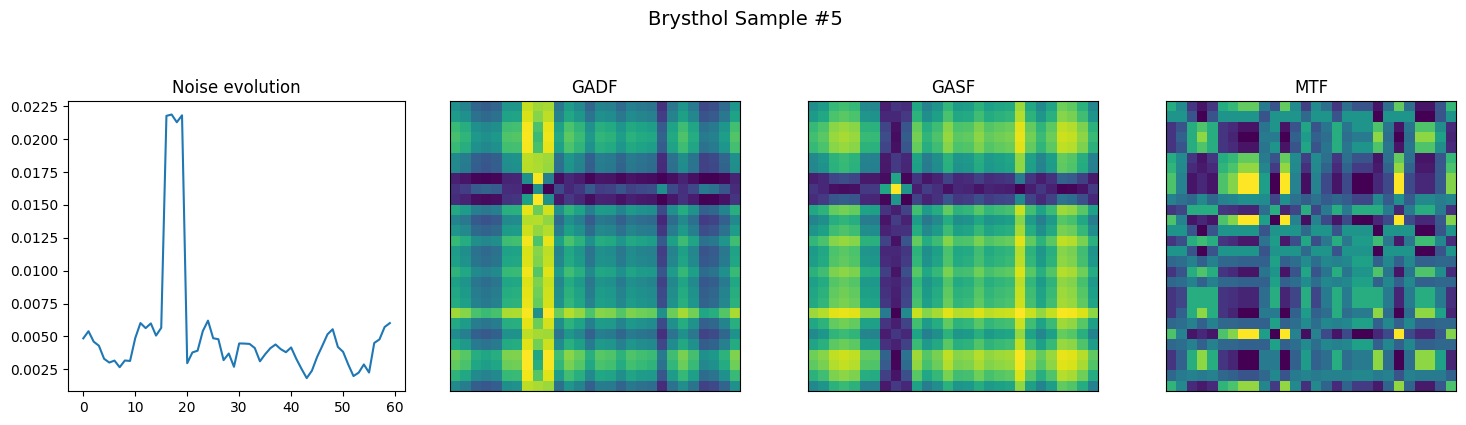

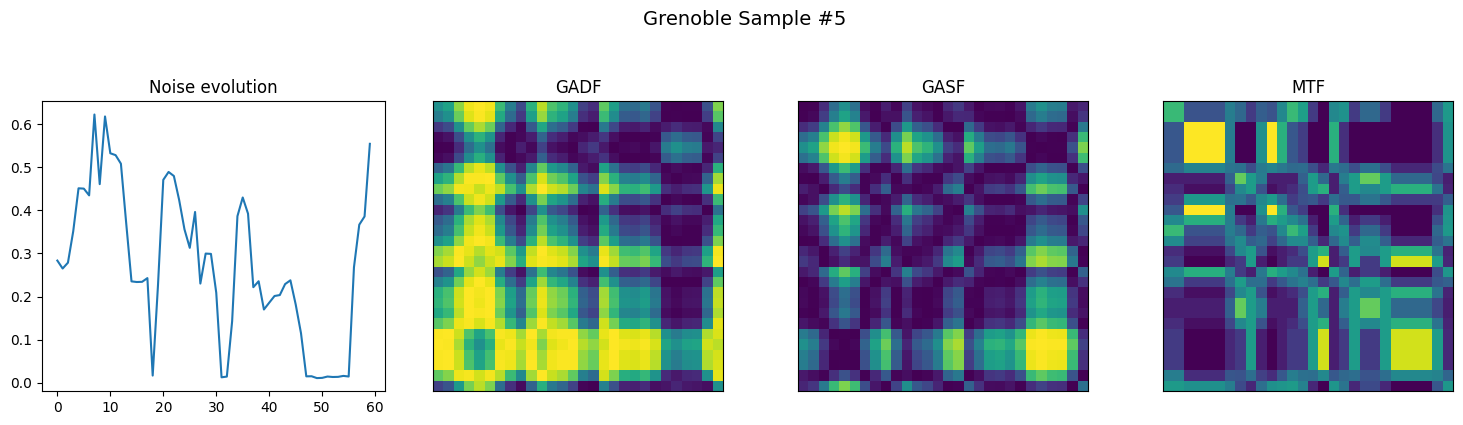

In [8]:
id = 5
visualize_sample(X_noise_brysthol[id], X_vae_brysthol[id], id, dataset_name='Brysthol')
visualize_sample(X_noise_grenoble[id], X_vae_grenoble[id], id, dataset_name='Grenoble')


## Constructing Pretraining Loaders

We concatenate source (Brysthol) and target (Grenoble) datasets to form the pretraining set. 
Labels are used only to track origin (1 = source, 0 = target) and are prepended to the input vector.


In [9]:
#  Sanity check: both domains must have the same signal length
Signal_dim = X_noise_brysthol.shape[1]
assert Signal_dim == X_noise_grenoble.shape[1]

#  Concatenate source + target domains for pretraining
X_noise_pretrain = np.concatenate((X_noise_brysthol, X_noise_grenoble), axis=0)
X_vae_pretrain = np.concatenate((X_vae_brysthol, X_vae_grenoble), axis=0)

#  Create dataset origin labels: 1 = Brysthol (source), 0 = Grenoble (target)
y_dataset = np.uint8([1] * len(X_noise_brysthol) + [0] * len(X_noise_grenoble))

#  Create targets for training by prepending the domain label to the signal
targets_pt = np.concatenate((y_dataset.reshape(-1, 1), X_noise_pretrain), axis=1)

#  Split into train/test for pretraining phase
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X_vae_pretrain,
    targets_pt,
    test_size=0.2,
    random_state=42
)

#  Wrap in PyTorch-style DataLoaders
train_loader_pt = array_to_loader(X_train_pt, y_train_pt, Signal_dim + 1)
test_loader_pt = array_to_loader(X_test_pt, y_test_pt, Signal_dim + 1)


## Model Pretraining on Signals Restitution From Images on Source & Target Datasets

In [10]:
# Model definition

kernel_size = 3 # (4, 4) kernel
init_channels = 16 # initial number of filters
image_channels = 3 

class VAE(nn.Module):
    """
    A convolutional Variational Autoencoder (VAE) for signal reconstruction from image inputs 
    (e.g. GADF, GASF, MTF). Encodes 2D image representations into latent vectors, 
    then decodes them into 1D signals. Includes a domain classification head 
    (e.g., source vs target).

    Args:
        latent_dim (int): Dimensionality of latent space
        h_dim1 (int): Hidden dimension for MLP decoder
        x_dim (int): Output signal length (reconstruction target)
    """

    def __init__(self, latent_dim, h_dim1, x_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size+1, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size+1, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size+1, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_log_var = nn.Linear(32, latent_dim)
        self.fc_classif = nn.Linear(latent_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=latent_dim, out_channels=latent_dim*2, kernel_size=kernel_size+1, 
            stride=2, padding=0
        )
        self.bn1 = nn.BatchNorm2d(num_features=latent_dim*2)
        self.dec2 = nn.ConvTranspose2d(
            in_channels=latent_dim*2, out_channels=latent_dim*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.bn2 = nn.BatchNorm2d(num_features=latent_dim*4)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.dec3 = nn.ConvTranspose2d(
            in_channels=latent_dim*4, out_channels=latent_dim*8, kernel_size=kernel_size+1, 
            stride=2, padding=1
        )
        self.bn3 = nn.BatchNorm2d(num_features=latent_dim*8)

        # self.dec4 = nn.ConvTranspose2d(
        #     in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size+1, 
        #     stride=2, padding=1
        # ) 
        # self.fc2 = nn.Linear(latent_dim, h_dim2)
        self.fc3 = nn.Linear(144*3*3, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        # h = F.relu(self.fc1(x))
        # h = F.relu(self.fc2(h))
        # return self.fc31(h), self.fc32(h) # mu, log_var

        # encoding
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = self.pool(F.relu(self.enc3(x)))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        # h = F.relu(self.fc2(z))
        # print(z.shape)
        h = z.view(-1, self.latent_dim, 1, 1)
        # print(h.shape)
        h = F.relu(self.dec1(h))
        # print(h.shape)
        h = self.bn1(h)
        h = self.bn2(self.pool(F.relu(self.dec2(h))))
        h = self.bn3(self.pool(F.relu(self.dec3(h))))
        # print(h.shape)
        h = h.view(-1, 144*3*3)
        h = F.relu(self.fc3(h))

        # print(h.shape)
        return F.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        # print(x.shape)
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        out = self.sigmoid(self.fc_classif(mu[:, :]))
        return self.decoder(z), mu, log_var, out, z

In [11]:
def loss_function(recon_x, x, mu, log_var, labels, out, history=None, coefs=[40, -0.1]):
    """
    Computes total VAE loss: weighted MSE + weighted KL divergence.

    Args:
        recon_x (Tensor): Reconstructed signal
        x (Tensor): Ground truth signal
        mu (Tensor): Latent mean
        log_var (Tensor): Latent log-variance
        labels (Tensor): Not used here (for potential extension)
        out (Tensor): Domain classification output (not used)
        history (dict): Optional dictionary to record metrics
        coefs (list): Weights for [reconstruction, KL divergence]

    Returns:
        loss (Tensor): Total loss value
    """
    MSE = coefs[0]*F.mse_loss(recon_x, x, reduction='sum')
    KLD = coefs[1]*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    if history :
        history['reconstruction'].append(MSE.detach().item())
        history['normalization'].append(KLD.detach().item())

    return KLD + MSE

def train(vae, train_loader, optimizer, epoch, history, coefs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, outputs) in enumerate(train_loader):
        # print(data.shape)
        optimizer.zero_grad()
        
        # print(data.shape)
        recon_batch, mu, log_var, out, z = vae(data)

        signals = outputs[:, 1:Signal_dim+1]
        labels = outputs[:, :1]
        # print(signals.shape, recon_batch.shape)

        loss = loss_function(recon_batch, signals, mu, log_var, labels, out, history, coefs)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test(vae, test_loader):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, outputs in test_loader:
            # data = data.cuda()
            recon, mu, log_var, out, z = vae(data)

            signals = outputs[:, 1:Signal_dim+1]
            labels = outputs[:, :1]
            
            # # sum up batch loss
            test_loss += loss_function(recon, signals, mu, log_var, labels, out).item()
            
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


###  Model Training

We now pretrain the VAE for signal reconstruction from image representations.  
The training loop runs for 19 epochs using the Adam optimizer and a custom loss function:

- **Reconstruction loss weight**: 30  
- **KL divergence penalty**: -0.3  
- Metrics are logged in the `history` dictionary for later inspection.


In [12]:
vae = VAE(latent_dim=18, h_dim1= 128, x_dim=Signal_dim)
optimizer = optim.Adam(vae.parameters())

history = {'reconstruction':[], 'classification':[], 'normalization':[]}
for epoch in range(1, 20):
    train(vae, train_loader_pt, optimizer, epoch, history, coefs=[30, -0.3])
    test(vae, test_loader_pt)

Train Epoch: 1 [0/44000 (0%)]	Loss: 290.030060
Train Epoch: 1 [6400/44000 (15%)]	Loss: 51.887383
Train Epoch: 1 [12800/44000 (29%)]	Loss: 50.090691
Train Epoch: 1 [19200/44000 (44%)]	Loss: 46.326874
Train Epoch: 1 [25600/44000 (58%)]	Loss: 53.924076
Train Epoch: 1 [32000/44000 (73%)]	Loss: 33.264225
Train Epoch: 1 [38400/44000 (87%)]	Loss: 40.172333
====> Epoch: 1 Average loss: 47.1047
====> Test set loss: 53.7136
Train Epoch: 2 [0/44000 (0%)]	Loss: 35.758450
Train Epoch: 2 [6400/44000 (15%)]	Loss: 39.087009
Train Epoch: 2 [12800/44000 (29%)]	Loss: 34.391880
Train Epoch: 2 [19200/44000 (44%)]	Loss: 31.473564
Train Epoch: 2 [25600/44000 (58%)]	Loss: 35.438995
Train Epoch: 2 [32000/44000 (73%)]	Loss: 34.017921
Train Epoch: 2 [38400/44000 (87%)]	Loss: 40.987850
====> Epoch: 2 Average loss: 35.2854
====> Test set loss: 43.5334
Train Epoch: 3 [0/44000 (0%)]	Loss: 39.200897
Train Epoch: 3 [6400/44000 (15%)]	Loss: 29.087307
Train Epoch: 3 [12800/44000 (29%)]	Loss: 28.196785
Train Epoch: 3 [19

### Embedding Extraction & Reconstruction Error

After training, we evaluate reconstruction quality by extracting:

- Latent embeddings from the encoder
- Reconstructed signals from the decoder
- Per-sample mean squared error (MSE) between predicted and true signals

This step allows visual comparison and downstream performance assessment.


In [13]:
embedding_train, y_emb_train, _, reconst_train, samples_train = investigate(vae, train_loader_pt, Signal_dim)
embedding_test, y_emb_test, _, reconst_test, samples_test = investigate(vae, test_loader_pt, Signal_dim)

reconst_error_train = np.mean((reconst_train[:, :Signal_dim]-reconst_train[:, Signal_dim:])**2, axis=1)
reconst_error_test = np.mean((reconst_test[:, :Signal_dim]-reconst_test[:, Signal_dim:])**2, axis=1)

### PCA Projection of Embeddings

To visualize how the latent space encodes the source and target domains, 
we apply **Principal Component Analysis (PCA)** to the latent embeddings and project them in 2D.

Each point represents one sample in latent space, and colors reflect the domain (source or target).


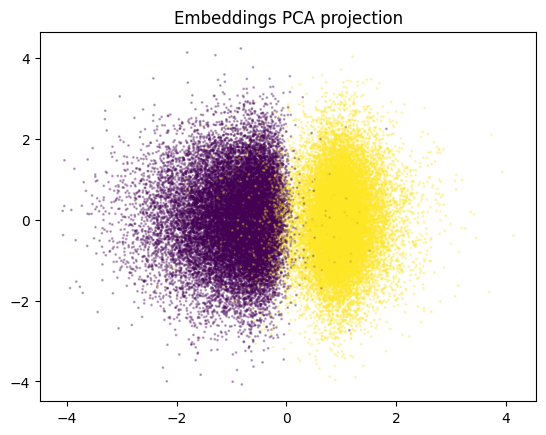

In [14]:

pca = PCA(n_components=samples_train.shape[1])
X_proj = pca.fit_transform(samples_train)

plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_emb_train[:], s=1, alpha=0.3)

plt.title('Embeddings PCA projection')
# plt.legend()
plt.show()

### Signal Reconstruction Quality

We now plot a randomly selected test signal to compare the **ground truth** and the **VAE reconstruction**.

This helps qualitatively assess how much detail the model retains in the signal during image-to-signal restitution.


1.0


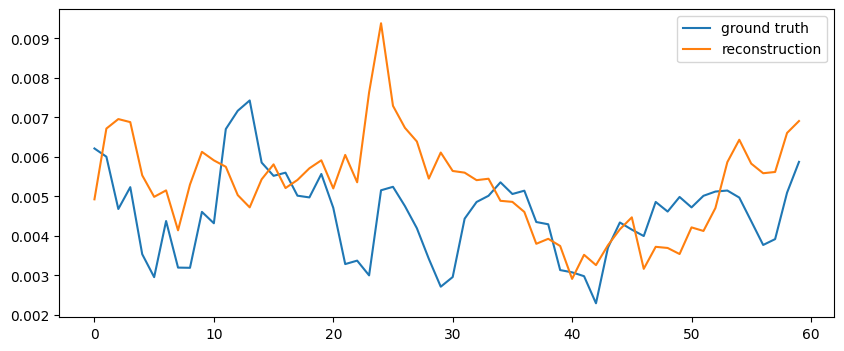

In [15]:
id  = 2
print(y_emb_test[id])
plt.figure(figsize=(10, 4))
plt.plot(reconst_test[id][: Signal_dim], label='ground truth')
plt.plot(reconst_test[id][Signal_dim:], label='reconstruction')
plt.legend()
plt.show()

## Source Dataset Augmentation using Nuisance Attributes from Target Dataset

We aim to transfer style/noise characteristics from the target domain to the source domain via PCA-guided latent space perturbations.


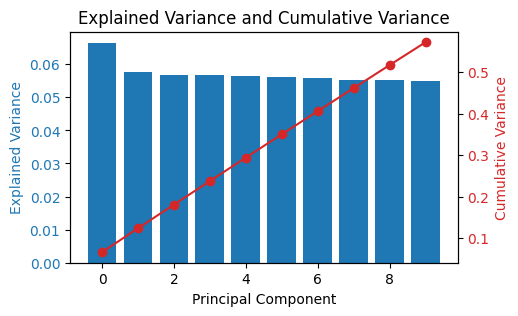

In [16]:
# Calculate explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance and cumulative variance
fig, ax1 = plt.subplots(figsize=(5, 3))

color = 'tab:blue'
ax1.bar(np.arange(len(explained_variance))[:10], explained_variance[:10], color=color)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.plot(np.arange(len(cumulative_variance))[:10], cumulative_variance[:10], color=color, marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Variance', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Explained Variance and Cumulative Variance')
plt.show()


In [18]:
targets_ft = np.concatenate((y_brysthol.reshape(-1, 1), X_noise_brysthol), axis=1)
ft_loader = array_to_loader(X_vae_brysthol, targets_ft, Signal_dim+1)

_, y_emb_ft1, _, reconst_ft1, samples_ft1 = investigate(vae, ft_loader, Signal_dim)
_, y_emb_ft2, _, reconst_ft2, samples_ft2 = investigate(vae, ft_loader, Signal_dim)


In [19]:
explained_variance = pca.explained_variance_ratio_
eigen_vecs = pca.components_ 

print(explained_variance.shape, eigen_vecs.shape)

gamma = 6
additive_components = [gamma*np.sum(eigen_vecs*explained_variance.reshape(-1, 1)*np.random.normal(0, 1, len(explained_variance)).reshape(-1, 1), axis=0) for _ in range(len(samples_ft1)+len(samples_ft2))]

augmented_ft_embeddings = np.concatenate((samples_ft1, samples_ft2)) + np.array(additive_components)
# augmented_ft_embeddings = np.concatenate((augmented_ft_embeddings, embedding_ft), axis=0)
print(np.array(additive_components).shape, augmented_ft_embeddings.shape)


(18,) (18, 18)
(55000, 18) (55000, 18)


In [20]:
X_noise_aug = vae.decoder(torch.tensor(augmented_ft_embeddings, dtype=torch.float32)).detach().numpy()
X_noise_res = X_noise_aug - np.concatenate((reconst_ft1, reconst_ft2))[:, 60:]
X_noise_brysthol_aug = np.concatenate((reconst_ft1, reconst_ft2))[:, :60] + X_noise_res
X_vae_aug = np.float32(transform_mtx(X_noise_brysthol_aug, list(range(X_noise_brysthol_aug.shape[1])), params_trans))
X_vae_aug[:, :2, :, :] = np.float32((X_vae_aug[:, :2, :, :]+1)/2)

## Model Fine-Tuning for Failure Prediction

In this stage, we fine-tune the VAE to perform binary classification (failure prediction) on augmented data. The objective combines reconstruction fidelity with prediction accuracy.


In [ ]:
model_path = 'CVAE_MLP_AUG_model_z_syn.pth'

In [21]:
y_ft = np.concatenate((y_emb_ft1, y_emb_ft2)).reshape(-1, 1)

targets_ft_aug = np.concatenate((y_ft, X_noise_brysthol_aug), axis=1)
# X_ft_aug, y_ft_aug, _  = preprocess_data_beta_grenoble(X_in_aug, targets_ft_aug, test_size=0.2, s_list=s_list)  

X_train, X_test, y_train, y_test = train_test_split(X_vae_aug, targets_ft_aug, test_size=0.2, random_state=42)
ft_aug_loader1 = array_to_loader(X_train, y_train, Signal_dim+1)
ft_aug_loader2 = array_to_loader(X_test, y_test, Signal_dim+1)

In [22]:
def loss_function_ft(recon_x, x, mu, log_var, labels, out, history=None, coefs=[2.5, 40, -0.1]):
    """
    Computes loss for fine-tuning VAE on classification and reconstruction.

    Args:
        recon_x: reconstructed signal
        x: original input signal
        mu: latent mean
        log_var: latent log variance
        labels: true binary labels
        out: predicted logits
        history: optional dict to store individual loss components
        coefs: weights for [classification_loss, reconstruction_loss, KL_divergence]

    Returns:
        Total weighted loss
    """

    BCE1 = coefs[0]*F.binary_cross_entropy(out, labels, reduction='sum')
    BCE2 = coefs[1]*F.mse_loss(recon_x, x, reduction='sum')
    KLD = coefs[2]*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    if history :
        history['reconstruction'].append(BCE2.detach().item())
        history['classification'].append(BCE1.detach().item())
        history['normalization'].append(KLD.detach().item())

    return KLD + BCE2 + BCE1

def train_ft(vae, train_loader, optimizer, epoch, history, coefs):
    """
    Fine-tunes the VAE model on a labeled dataset using a combined loss 
    that accounts for reconstruction, classification, and KL divergence.

    Args:
        vae (nn.Module): The VAE model to be trained.
        train_loader (DataLoader): DataLoader providing batches of (image, target) pairs.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        epoch (int): Current training epoch (for logging).
        history (dict): Dictionary to accumulate loss components over time.
                        Keys: 'reconstruction', 'classification', 'normalization'
        coefs (list): List of loss weights [BCE1, BCE2, KLD].

    Returns:
        None
    """
    vae.train()
    train_loss = 0
    for batch_idx, (data, outputs) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        
        recon_batch, mu, log_var, out, z = vae(data)

        signals = outputs[:, 1:Signal_dim+1]
        labels = outputs[:, :1]
        

        loss = loss_function_ft(recon_batch, signals, mu, log_var, labels, out, history, coefs)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def accuracy(vae, loader): 
    """
    Computes binary classification accuracy on the given dataset using the VAE model.

    Args:
        vae (nn.Module): Trained VAE model.
        loader (DataLoader): DataLoader providing input batches.

    Returns:
        float: Accuracy score (between 0 and 1).
    """
    embedding, y_emb, y_pred, reconst, samples = investigate(vae, loader)
    accuracy = accuracy_score(y_emb[:].flatten(), y_pred[:].flatten()>0.5) 
    return accuracy

In [ ]:
targets_test_test = np.concatenate((y_brysthol.reshape(-1, 1), X_noise_brysthol), axis=1)

train_loader_test_test = array_to_loader(X_vae_brysthol, targets_test_test, Signal_dim+1)

vae = VAE(latent_dim=18, h_dim1= 128, x_dim=Signal_dim)
vae.load_state_dict(torch.load(model_path))

optimizer = optim.Adam(vae.parameters())
history = {'reconstruction':[], 'classification':[], 'normalization':[]}

Acc = {'train':[], 'val':[]}
for epoch in range(1, 30):
    train_ft(vae, ft_aug_loader1, optimizer, epoch, history, coefs=[2.5, 20, -0.01])
    # test(vae, test_loader_pt) 
    Acc['train'].append(accuracy(vae, ft_aug_loader1))
    Acc['val'].append(accuracy(vae, train_loader_test_test))

FileNotFoundError: [Errno 2] No such file or directory: '/dbfs/mnt/xr51wedxfr/Tracability/Test_salah/CVAE_MLP_AUG_model_z_syn.pth'

In [ ]:
epchs = list(range(1, len(Acc['train'])+1))
plt.plot(epchs, Acc['train'], c='b', alpha=0.8, label='augmented dataset')
epchs = list(range(1, len(Acc['val'])+1))
plt.plot(epchs, Acc['val'], '--', c='orange', alpha=0.8, label='source dataset')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot((np.array(history['reconstruction'])/history['reconstruction'][0]), alpha=0.7, label='reconstruction loss')

plt.plot((np.array(history['classification'])/history['classification'][0]), alpha=0.7, label='classification loss')

plt.xlabel('steps')
plt.ylabel('normalized loss')
plt.legend()
plt.show()


In [ ]:
embedding_test_test, y_emb_test_test, y_pred_test_test, reconst_test_test, samples_test_test = investigate(vae, train_loader_test_test)
accuracy_test_test = accuracy_score(y_emb_test_test[:].flatten(), y_pred_test_test[:].flatten()>0.5)
print("finetune accuracy score : ", round((accuracy_test_test)*100, 2))

In [24]:
embedding_ft, y_emb_ft, y_pred_ft, reconst_ft, samples_ft = investigate(vae, ft_aug_loader1)
accuracy_ft = accuracy_score(y_emb_ft[:].flatten(), y_pred_ft[:].flatten()>0.5)
print("finetune accuracy score : ", round((accuracy_ft)*100, 2))

TypeError: investigate() missing 1 required positional argument: 'Signal_dim'